<h1 align="center">Оценка качества моделей и отбор признаков</h1>

МФТИ ФИВТ: Курс Машинное Обучение (осень, 2016), Зухба Анастасия, a__l@mail.ru

<h1 align="center">Organization Info</h1> 

**Дополнительный материал для выполнения дз**:



**Оформление дз**: 
- Присылайте выполненное задание на почту ``ml.course.mipt@gmail.com``
- Укажите тему письма в следующем формате ``ML2016_fall <номер_группы> <фамилия>``, к примеру -- ``ML2016_fall 401 ivanov``
- Выполненное дз сохраните в файл ``<фамилия>_<группа>_task<номер>.ipnb``, к примеру -- ``ivanov_401_task1.ipnb``

**Вопросы**:
- Присылайте вопросы на почту ``ml.course.mipt@gmail.com``
- Укажите тему письма в следующем формате ``ML2016_fall Question <Содержание вопроса>``

--------
- **PS1**: Мы используем автоматические фильтры, и просто не найдем ваше дз, если вы не аккуратно его подпишите.
- **PS2**: Напоминаем, что дедлайны жесткие, письма пришедшие после автоматически удаляются =( чтобы соблазна не было 

<h1 align="center">Check Questions</h1> 

Ответе на вопросы своими словами (загугленный материал надо пересказать), ответ обоснуйте (напишите и ОБЪЯСНИТЕ формулки если потребуется), если не выходит, то вернитесь к лекции дополнительным материалам:

**Вопрос 1**: В каких ситуациях полезно использовать AUC-ROC?

<Ответ>

**Вопрос 2**: Когда использование precision/recall предпочтительнее, чем AUC-ROC?

<Ответ>

**Вопрос 3**: Для чего используются внутренние критерии, а для чего внешние?

<Ответ>

**Вопрос 4**: Чем эмпирические критерии отличаются от аналитических?

<Ответ>

**Вопрос 5**: Что такое критерий регуляризации?

<Ответ>

# Определение спама по тексту электронного письма

Попробуем при помощи моделей машинного обучения построить алгоритм, отделяющий спам от нормальной почты. Для экспериментов воспользуемся небольшим набором данных с UCI. Объекты в датасете соответствуют письмам, которые описаны признаками на основе текста письма, спам — положительный пример для классификации, хорошее письмо — отрицательный пример.

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Загрузка датасета Spambase

In [2]:
import pandas
import urllib2

SPAMBASE_NAMES_URL = 'https://archive.ics.uci.edu/ml/machine-learning-databases/spambase/spambase.names'
SPAMBASE_DATA_URL = 'https://archive.ics.uci.edu/ml/machine-learning-databases/spambase/spambase.data'

feature_names = [
    line.strip().split(':')[0] 
    for line in urllib2.urlopen(SPAMBASE_NAMES_URL).readlines()[33:]
]
spam_data = pandas.read_csv(SPAMBASE_DATA_URL, header=None, names=(feature_names + ['spam']))
 
X, y = spam_data.ix[:, :-1].values, spam_data.ix[:, -1].values
 
spam_data.head()

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,...,char_freq_;,char_freq_(,char_freq_[,char_freq_!,char_freq_$,char_freq_#,capital_run_length_average,capital_run_length_longest,capital_run_length_total,spam
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.00,0.000,0.0,0.778,0.000,0.000,3.756,61,278,1
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,...,0.00,0.132,0.0,0.372,0.180,0.048,5.114,101,1028,1
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.01,0.143,0.0,0.276,0.184,0.010,9.821,485,2259,1
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.137,0.0,0.137,0.000,0.000,3.537,40,191,1
4,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.135,0.0,0.135,0.000,0.000,3.537,40,191,1


**Задание**
- Сколько примеров писем в датасете?
- Какова доля плохих писем?
- Какие характерные группы признаков представлены в наборе?

### Обучение классификатора и оценка его качества

Обучение и оценка качества модели производится на независимых множествах примеров. Как правило, имеющующиеся примеры разбивают на два подмножества: обучение (train) и контроль (test). Выбор пропорции разбиения — компромисс: большой размер обучения ведет к более богатым информацией и качественным алгоритмам, большой размер контрольной выборки ведет к менее шумной оценке качества.

Для оценки качества классификации рассматривают матрицу ошибок: строчки соответствуют истинному классу, столбцы — предсказанному классификатором, ячейки содержат число примеров тестовой выборки.

<img src="confusion_matrix.png">

Диагональ матрицы ошибок содержит правильно классифицированные положительные (TP) и отрицательные (TN) примеры. False Positive (FP) — ошибки I рода (ложное срабатывание, положили в спам хорошее письмо), False Negative (FN) — ошибки II рода (не отфильтровали спам). Ошибки I и II рода могут иметь различную стоимость.

Часто рассматриваются следующие метрики качества бинарной классификации:

- Accuracy = (TP + TN) / (TP + TN + FP + FN) — доля правильных ответов
- Precision = TP / (TP + FP) — точность, доля спама среди писем, классифицированных как спам
- Recall = TP / (TP + FN) — полнота, доля спама, которая была отфильтрована
- F1 = 2TP / (2TP + FP + FN) — среднее гармоническое между точностью и полнотой

**Задание**
- Разбейте набор примеров на две непересекающиеся подвыборки следующим образом: train — первые 3000 примеров (≈65%), test — все остальные примеры.
- Обучите решающее дерево на train. Классифицируйте примеры из test. Посчитайте метрики качества классификации, описанные выше: Accuracy, Precision, Recall, F1. Рекомендованные параметры решающего дерева: разбиение по критерию gini, максимальная глубина: 7.
- Какие есть недостатки у получившейся оценки качества на подвыборке test? Как можно сделать оценку качества более информативной?
- Повторите эксперимент, перемешав случайно объекты исходной выборки перед разбиением.
- Какие признаки оказались наиболее важными для определения спама? Воспользуйтесь оценками важности признаков, полученых при построении решающего дерева.
- Какое качество дает лучшая константная модель (определяющая класс определенно и вне зависимости от признаков)?
- Обучите модель KNN и оцените ее качество на test. Рекомендованные параметры: K=10, евклидова метрика в качестве расстояния.
- Обучите модель KNN, предварительно приведя значения признаков к одинаковому масштабу. Оцените качество полученной модели на test. Дает ли подобное преобразование признаков прирост качества для модели KNN? Проделайте тот же эксперимент с решающим деревом. Почему масштабирование признаков не влияет на качество решающего дерева, но повышает качество классификации модели KNN?
- Сравните все обученные модели по всем метрикам.


В итоге должны быть построены и сравнены между собой следующие модели:

1) Константная модель
2) Решающее дерево
3) KNN
4) KNN с масштабированием признаков

### Выбор порога классификации

Многие модели классификации получают оценку принадлежности положительному классу $y'(x)\in R$. Затем принимают решение о классе объекта путем сравнения оценки с порогом: $y(x)=+1$, если $y'(x)<\theta$, $y(x)=−1$, если $y'(x)\geq\theta$

Матрица ошибок и все производные от нее метрики (Accuracy, Precision, Recall, etc.) зависят от порога $\theta$.


<img src="binary_threshold.png">

Для того чтобы видеть изменения метрик при всех значениях порога классификации, рассматривают координатную плоскость, по осям которой отложены значения метрик, а качество работы классификатора представлено в виде кривой — траектории изменения соответствующих метрик при варьировании порога:

<img src="roc_trajectory.png">

Наиболее распространены ROC-кривые (плоскость TP-vs-FP) и Precision/Recall кривые. Аббревиатура ROC (Receiver Operating Characteristic) была унаследована из инженерного дела.

<img src="roc_and_pr_curves.png">

В случае, если необходимо сравнить качество классификаторов вне зависимости от порога, применяют интегральные числовые метрики, например AUC-ROC (Area Under ROC) — площадь под ROC-кривой классификатора. AUC-ROC идеально работающего классификатора равно 1. Идеальный случайный классификатор в среднем имеет AUC-ROC=0.5.



**Задача 1**

 Определите функционал «доля дефектных пар» для задачи бинарной классификации. Как данный функционал связан с AUC-ROC?

**<Решение>**

**Задача 2**

Приведите пример целевого вектора $y_1, \ldots , y_l$ и ответов алгоритма $b(x_1),\ldots,b(x_l)$, для которых AUC-ROC будет равен 0.5.


**<Решение>**

**Задание**

 Верно ли, что классификаторы из предыдущей части действуют путем сравнения некоторой оценки принадлежности положительному классу с порогом? Что это за оценки принадлежности? Какие пороги были выбраны?
 
 Для всех моделей, построенных в предыдущем задании:
- Постройте ROC и Precision/Recall кривые в одних координатных осях, линиями разных цветов. Добавьте легенду: какая кривая соответствует какому классификатору.
- Сравните значения AUC-ROC.

Какой максимальной полноты определения спама достигают построенные классификаторы, если перед вами стоит жесткое ограничение: точность классификатора не может быть меньше 90%?



### Кросс-валидация и подбор параметров

Каждая модель машинного обучения имеет множество структурных параметров и параметров обучения: число соседей и тип функции расстояния в KNN, максимальная высота дерева, минимальное число объектов в листе дерева и т.д. Нет универсальных наборов параметров, оптимально работающих во всех задачах, для каждой задачи нужно подбирать свой набор параметров.

Для оптимизации параметров модели часто используют перебор по сетке (grid search): для каждого параметра выбирается несколько значений, перебираются все комбинации значений параметров и выбирается комбинация, на которой модель показывает лучшее качество (с точки зрения метрики, которая оптимизируется).

Сравнение большого числа моделей при переборе параметров приводит к ситуации, когда лучшая на тестовой подвыборке модель не сохраняет свои качества на новых данных. Можно сказать, что происходит переобучение на тестовую выборку.

Для устранения этой проблемы, данные разбивают на 3 непересекающихся подвыборки: обучение (train), валидация (validation) и контроль (test).

Валидационную подвыборку используют для сравнения моделей, а test — для окончательной оценки качества и сравнения семейств моделей с подобранными параметрами.

Более надежный способ объективного сравнения моделей — кросс-валидация. Существуют различные схемы кросс-валидации:

- Leave-One-Out
- K-Fold
- Многократное случайное разбиение выборки
Кросс-валидация вычислительно затратна, особенно если вы делаете перебор по сетке с очень большим числом комбинаций. С учетом конечности времени на выполнение задания, возникает ряд компромиссов:

- сетку можно делать более разреженной, перебирая меньше значений каждого параметра, но в таком случае можно пропустить хорошую комбинацию параметров;
- кросс-валидацию можно делать с меньшим числом разбиений или фолдов, но в таком случае оценка качества кросс-валидации становится более шумной и увеличивается риск выбрать неоптимальный набор параметров из-за случайности разбиения;
- параметры можно оптимизировать последовательно (жадно) — один за другим, а не перебирать все комбинации; такая стратегия не всегда приводит к оптимальному набору;
- перебирать не все комбинации параметров, а небольшое число случайно выбранных.

**Задание**
- Выберите схему кросс-валидаци, одну из перечисленных выше. Зафиксируйте разбиение кросс-валидации обучающей выборки. Кросс-валидировать нужно по выборке train из предыдущих заданий, test должен остаться независимым. Обратите внимание: при сравнении моделей, набор разбиений кросс-валидации не должен меняться, должен быть строго фиксированным.
- Выберите одну метрику, которую будете оптимизировать при переборе параметров. Например, можно взять AUC-ROC.
- Найдите оптимальный набор параметров дерева, перебрав значения параметров по сетке. Параметры для настройки: критерий разбиения, максимальная глубина, число признаков для каждого узла, минимальное число объектов в листе (или часть из этих параметров).
- Найдите оптимальный набор параметров для KNN, перебрав значения параметров по сетке. Параметры для настройки: число соседей, функция расстояния, схема взвешивания (или часть из этих параметров).
- Сравните полученные модели с моделями из предыдущих заданий. Сравнение необходимо проводить на тестовой выборке, которая не участвовала в подборе и обучении. Сравнение нужно проводить только по метрике которая оптимизировалась.

<h1 align="center">Примеры</h1> 

## Обучение решающего дерева

In [3]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier

iris_data = load_iris()
X, y = iris_data.data, iris_data.target

clf = DecisionTreeClassifier(max_depth=3).fit(X, y)

y_pred = clf.predict(X)

#### Важность признаков

Важность признаков вычисляется на основании частоты разбиения по признаку и глубины узлов дерева в которых происходило разбиение по признаку.

In [4]:
most_important_features = argsort(clf.feature_importances_)[::-1]
for idx in most_important_features:
    print '%d %s, importance = %.2f' % (idx, iris_data.feature_names[idx], clf.feature_importances_[idx])

3 petal width (cm), importance = 0.95
2 petal length (cm), importance = 0.05
1 sepal width (cm), importance = 0.00
0 sepal length (cm), importance = 0.00


#### Ошибочно классифицированные объекты обучающей выборки

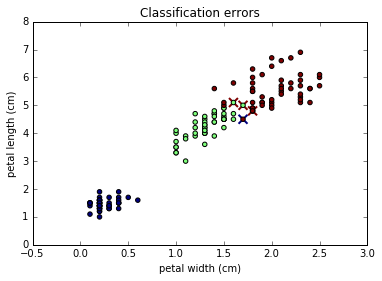

In [5]:
xind, yind = most_important_features[0], most_important_features[1]
err = (y != y_pred)
scatter(X[err, xind], X[err, yind], c=y_pred[err], marker='x', s=80, linewidths=2)
scatter(X[:, xind], X[:, yind], c=y)
xlabel(iris_data.feature_names[xind])
ylabel(iris_data.feature_names[yind])
title(u'Classification errors')

#### Визуализация дерева

In [6]:
from sklearn.tree import export_graphviz
export_graphviz(clf, out_file='tree.dot', feature_names=iris_data.feature_names)

In [7]:
!dot -Tpng tree.dot -o tree.png

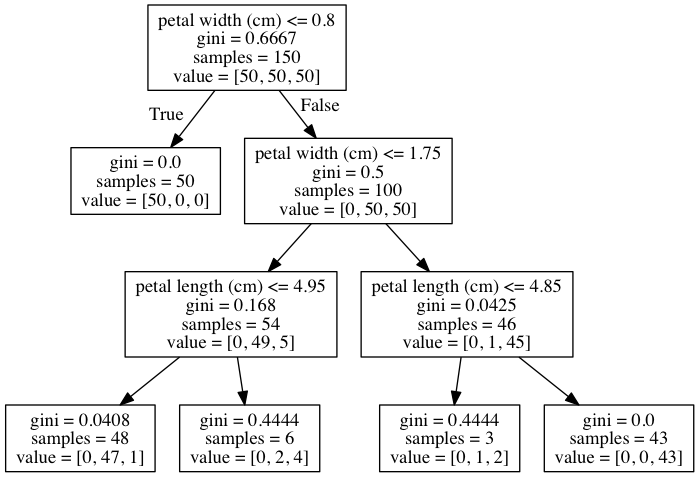

In [8]:
from IPython.display import Image
Image('tree.png')

## Кросс-валидация

In [9]:
from sklearn.datasets import load_boston
boston_data = load_boston()
X, y = boston_data.data, boston_data.target

Зафиксируем разбиение для 5-fold кросс-валидации.

In [10]:
from sklearn.cross_validation import KFold
cv = KFold(n=len(y), n_folds=5, shuffle=True, random_state=123)

Обратите внимание на аргументы:
 

- shuffle=True — без него фолды будут формироваться из последовательно идущих объектов, что нехорошо — в этом поможет убедиться задание в части 2;
- random_state — если этот параметр не выставить, то после каждого запуска команды будет генерироваться новое разбиение на фолды; крайне желательно, чтобы ваши эксперименты были в точности воспроизводимы — это упрощает исследования.


Оценим качество регрессии KNN на наборе Boston Housing для различных значений K (число соседей). В качестве метрики качества возьмем модуль отклонения:

 $MAE=\sum_i|y_{pred,i}-y_i|$


In [11]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.cross_validation import cross_val_score

Переберем ряд значений n_neigbors, для каждого оценим среднее и стандартное отклонение MAE по кросс-валидации. Магия %%time позволяет измерить время работы ячейки с кодом.

In [12]:
%%time 

k_values = range(1, 10) + range(10, 50, 5)
mae_cv_mean = []
mae_cv_std = []

for k in k_values:
    clf = KNeighborsRegressor(n_neighbors=k)
    mae_folds = -cross_val_score(clf, X, y, cv=cv, scoring='mean_absolute_error')
    mae_cv_mean.append(mae_folds.mean())
    mae_cv_std.append(mae_folds.std())

CPU times: user 390 ms, sys: 23 ms, total: 413 ms
Wall time: 461 ms


#### График, демонстрирующий оптимальность выбора числа соседей

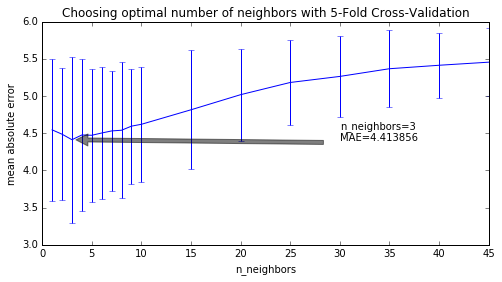

In [13]:
figure(figsize=(8, 4))
errorbar(k_values, mae_cv_mean, yerr=array(mae_cv_std)*2)
title('Choosing optimal number of neighbors with 5-Fold Cross-Validation')
xlabel('n_neighbors')
ylabel('mean absolute error')

opt_idx = argmin(mae_cv_mean)
optimal_k = k_values[opt_idx]
optimal_mae = mae_cv_mean[opt_idx]
annotate('n_neighbors=%d\nMAE=%f' % (optimal_k, optimal_mae), 
         xy=(opt_idx, optimal_mae), xytext=(30, optimal_mae), 
         arrowprops=dict(facecolor='black', shrink=0.05, alpha=0.5))